In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skpsl.preprocessing import MinEntropyBinarizer
from scipy.stats import entropy
from operator import itemgetter
from tqdm import tqdm
import networkx as nx

In [127]:
df = pd.read_csv("data/player_processed.csv")
y = df.iloc[:,0]
X = MinEntropyBinarizer().fit_transform(df.iloc[:,1:],y)
n = X.shape[1]

In [128]:
def eentropy(f):
    # group by the features in f
    keys, weights = np.unique(X[:,f], axis=0, return_counts=True)

    # calculate entropy and number of elements
    ents = [entropy(np.unique(y[np.all(X[:,f]==i, axis=1)], return_counts=True)[1]) for i in keys]
    return np.average(ents, weights=weights), f

In [129]:
f = []
while len(f) < n:
    # entropy of using features f
    ent, f = min(map(lambda x: eentropy(f+[x]), list(set(range(n)) - set(f))), key=itemgetter(0))
f

[3, 10, 9, 4, 2, 1, 5, 6, 0, 7, 11, 8]

In [130]:
# sample ordering of features
# start with original ordering
X = X[:,f]

# calculate entropy at after every feature split
keys, counts = np.unique(y, return_counts=True)
classes = keys
entropies = {"":entropy(counts)}
dists =  {"":list(map(itemgetter(1), sorted(zip(list(keys), list(counts)), key=itemgetter(0))))}
full_dists = dict()
for i in range(1,1+n):
    for j in range(2**i):
        key = f"{j:0{i}b}"
        mask = np.array(list(key)).astype(int)
        data = y[np.all(X[:,:i]==mask, axis=1)]
        keys, counts = np.unique(data, return_counts=True)

        entropies[key] = entropy(counts)
        dists[key] = [(counts[list(keys).index(c)] if c in keys else 0) for c in classes]
        full_dists[key] = dict(zip(list(keys), list(counts)))

entropie_diff = dict()
for i in range(n):
    for j in range(2**i):
        if i == 0:
            key = ""
        else:
            key = f"{j:0{i}b}"
        w = [sum(full_dists[key+"0"].values()),sum(full_dists[key+"1"].values())]
        if sum(w) == 0:
            entropie_diff[key]=0
        else:
            entropie_diff[key] =entropies[key] -  np.average([entropies[key+"0"],entropies[key+"1"]], weights=w )

lines = []
for datapoint in tqdm(X):
    line = [entropies[""]]
    for prefix in range(len(datapoint)):
        key = "".join(datapoint[:prefix+1].astype(str))
        line.append(entropies[key])
    lines.append(line)

100%|██████████| 3611/3611 [00:00<00:00, 14960.48it/s]


<Axes: >

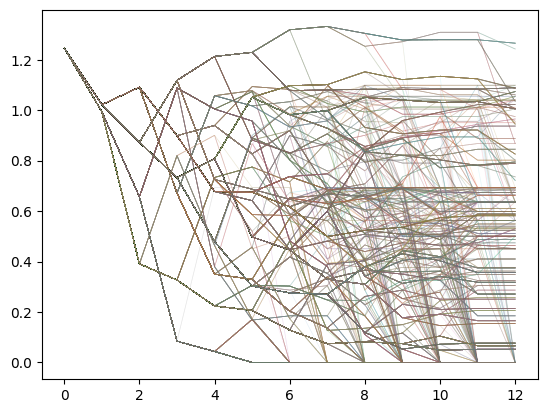

In [131]:
pd.DataFrame(lines).T.plot(legend=False, lw=.5, alpha=.1)

Text(0.5, 1.0, 'Cummulative information gain at each stage')

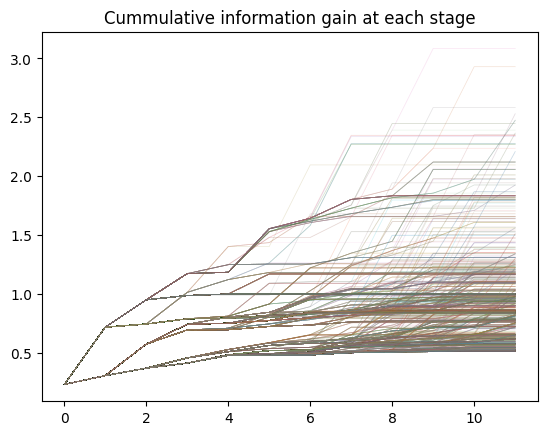

In [132]:
lines = []
for datapoint in X:
    line = [entropie_diff[""]]
    for prefix in range(len(datapoint)-1):
        key = "".join(datapoint[:prefix+1].astype(str))
        line.append(entropie_diff[key])
    lines.append(np.cumsum(line))

pd.DataFrame(lines).T.plot(legend=False, lw=.5, alpha=.1)
plt.title("Cummulative information gain at each stage")

Text(0.5, 1.0, 'Information gain per feature at stage')

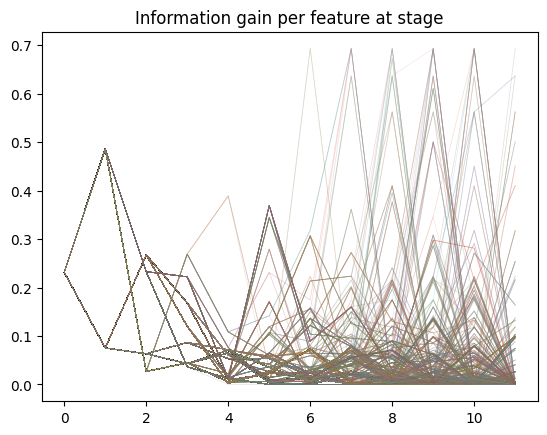

In [133]:
lines = []
for datapoint in X:
    line = [entropie_diff[""]]
    for prefix in range(len(datapoint)-1):
        key = "".join(datapoint[:prefix+1].astype(str))
        line.append(entropie_diff[key])
    lines.append(line)
pd.DataFrame(lines).T.plot(legend=False, lw=.5, alpha=.1)
plt.title("Information gain per feature at stage")

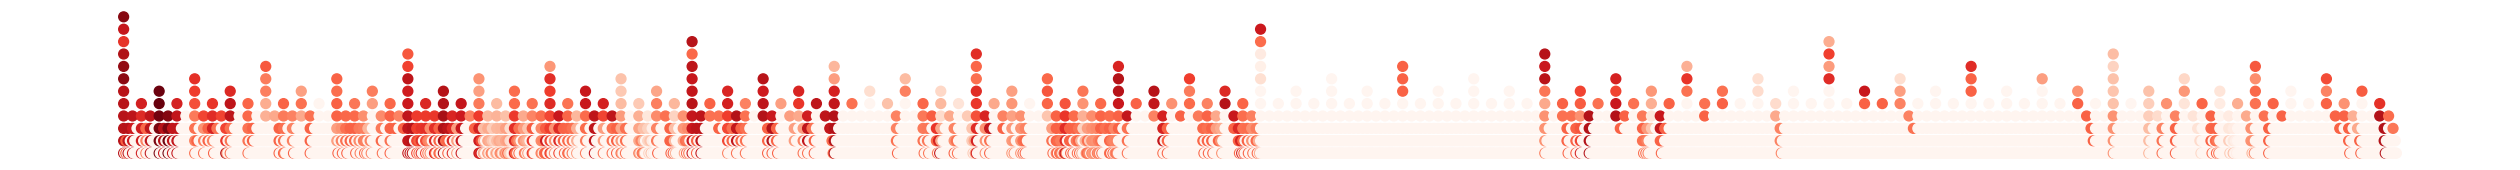

In [152]:
depth = 12
g = nx.Graph()
g.add_nodes_from([(k,dict(dist=dist,ent=ent,ig=ig)) for (k,dist),ent,ig in zip(dists.items(),entropies.values(),entropie_diff.values()) if len(k)<depth])
#g.add_edges_from([(k[:-1],k) for k in dists.keys() if 0< len(k)<depth])
plt.figure(figsize=(25,1.5))
nx.draw(g, pos={k:(int("0"+k,2)/2**(len(k)),-len(k)) for k in g.nodes}, 
        #labels= {k: f"ent:{g.nodes[k]['ent']:.3f}\n{str(g.nodes[k]['dist'])[1:-1]}" for k in g.nodes}, 
        node_size=50, 
        node_color=[g.nodes[k]['ent'] for k in g.nodes],cmap=plt.cm.Reds)

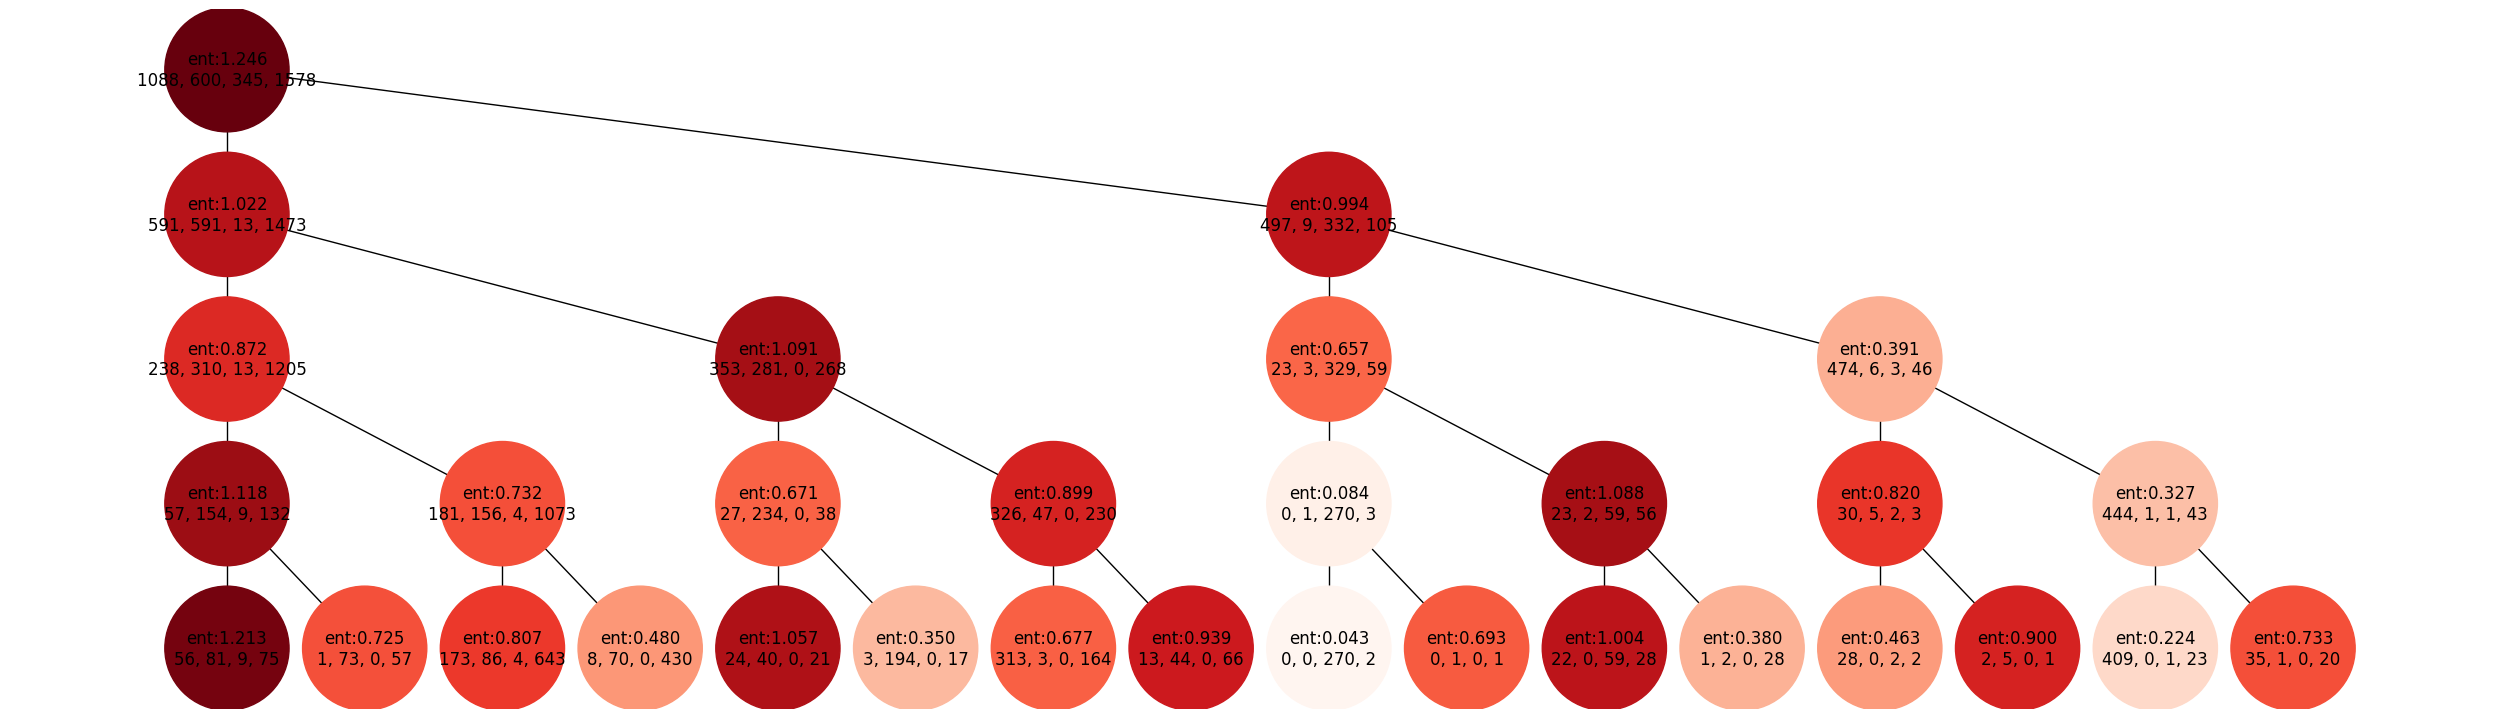

In [151]:
depth = 5
g = nx.Graph()
g.add_nodes_from([(k,dict(dist=dist,ent=ent,ig=ig)) for (k,dist),ent,ig in zip(dists.items(),entropies.values(),entropie_diff.values()) if len(k)<depth])
g.add_edges_from([(k[:-1],k) for k in dists.keys() if 0< len(k)<depth])
plt.figure(figsize=(25,7))
nx.draw(g, pos={k:(int("0"+k,2)/2**(len(k)),-len(k)) for k in g.nodes}, 
        labels= {k: f"ent:{g.nodes[k]['ent']:.3f}\n{str(g.nodes[k]['dist'])[1:-1]}" for k in g.nodes}, 
        node_size=8000, 
        node_color=[g.nodes[k]['ent'] for k in g.nodes],cmap=plt.cm.Reds)